## Training Tensorflow 1.x Model for MNIST
This post consists of:

1. Libraries
2. Loading dataset
3. Setting Hyperparameters
4. Normalization
5. Defining Network
6. Training
7. Model Config
    1. Network architecture
    2. Learning rate value

### 1.1 Import Libraries

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### 1.2 Load MNIST Dataset

11493376/11490434 [==============================] - 0s 0us/step


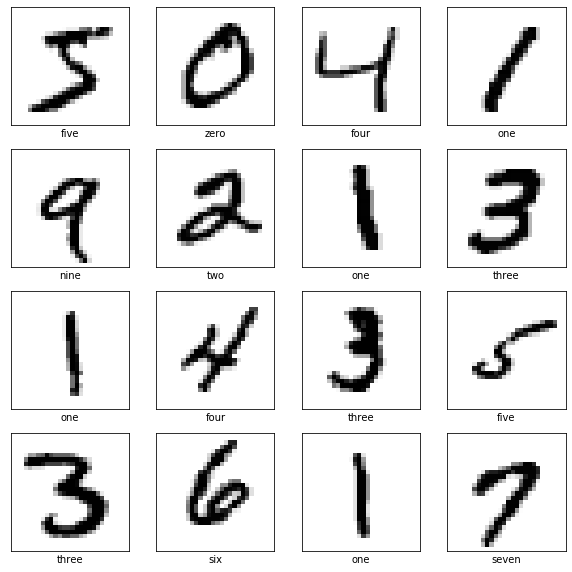

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
class_names = ['zero', 'one', 'two', 'three', 'four', 'five',
               'six', 'seven', 'eight', 'nine']

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

### 1.3 Setting Hyperparameters

In [ ]:
learning_rate = 0.5
epochs = 10
batch_size = 128
hidden_size = 400
shape = x_train.shape[1:]
input_size = shape[0]*shape[1]
std = 0.03

### 1.4 Normalization

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = tf.cast(tf.reshape(dataset, (-1, image_size * image_size)), tf.float32)
    labels = tf.one_hot(labels, depth=num_labels)
    return dataset, labels
train_dataset, train_labels = reformat(x_train, y_train)
test_dataset, test_labels = reformat(x_test, y_test)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (60000, 784) (60000, 10)
Test set (10000, 784) (10000, 10)


### 1.5 Defining Network 

In [ ]:
hidden_size = 1024

# Input data.
# Load the training, and test data
tf_train_dataset = train_dataset
tf_train_labels = train_labels
tf_test_dataset = test_dataset

# Variables.
# These are the parameters that we are going to be training. The weight
# matrix will be initialized using random values following a (truncated)
# normal distribution. The biases get initialized to zero.
weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
biases_1 = tf.Variable(tf.zeros([hidden_size]))
layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)

# layer2  
weights_2 = tf.Variable(tf.truncated_normal([hidden_size,num_labels]))
biases_2 = tf.Variable(tf.zeros([num_labels]))
# Training computation.
layer_2 = tf.matmul(layer_1,weights_2) + biases_2

# calculating (Loss)' = loss + l2_regularization
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=layer_2))

# Training computation.
# We multiply the inputs with the weight matrix, and add biases. We compute
# the softmax and cross-entropy. We take the average of this
# cross-entropy across all training examples: that's our loss.

# Optimizer.
# We are going to find the minimum of this loss using gradient descent.
optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

# Predictions for the training and test data.
train_prediction = tf.nn.softmax(layer_2)
test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2)+ biases_2)

### 1.6 Training 

In [78]:
num_steps = 301

def accuracy(predictions, labels):
    z = tf.equal(tf.argmax(predictions, axis=1), tf.argmax(labels, axis=1))
    z = tf.cast(z, tf.float32)
    z = tf.reduce_sum(z, keepdims=True)
    z = z * 100./ tf.cast(predictions.shape[0], tf.float32)
    return (z.eval())
  

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
        print('Loss at step %d: %f' % (step, l))
        print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels))
        # Calling .eval() on valid_prediction is basically like calling run(), but
        # just to get that one numpy array.
        print('Test accuracy: %.1f%%' % accuracy(test_prediction, test_labels))
    ff = test_prediction.eval()

Initialized
Loss at step 0: 73913.359375
Training accuracy: 10.2%
Test accuracy: 10.1%
Loss at step 100: 3622.128906
Training accuracy: 79.9%
Test accuracy: 80.6%
Loss at step 200: 2568.829834
Training accuracy: 84.5%
Test accuracy: 84.8%
Loss at step 300: 2103.153320
Training accuracy: 86.6%
Test accuracy: 86.4%


### 1.7 Model Config
1. Network Architecture
2. Learning Rate Value

#### 1.7.1 Network Architecture

A 2-layer(with input 3) network with 1024 hidden units has been chosen. As we are passing the images itself without any manual or automatical feature extraction (like CNN), 784 feature per image which are spatially relevant can cause underfitting on small networks so increasing number of hidden neurons or hidden layers(in my case hidden neurons) can lead to better learning but as we grow the number of parameters it is important to consider overfitting though.

Gradient Descent has been chosen as the optimizer of the loss which is cross-entropy loss.

Biases are initialized 0 and weights using small random numbers (a different version in TF1).

The linearity between hidden layers has been handled using ReLU activation function which finally classification handled by soft-max activation.

I've test a few different configs all for 300 epochs which only this config achieved accuracy higher than %80.
The other configs are these:

1. 300 Hidden neurons, LR = 0.5
2. 400 Hidden Neurons, LR = {0.5, 0.01, 0.001}
3. 1024 Hidden Neurons, LR = {0.5, 0.01, 0.001, 0.0001}

Note that bigger learning rates like 0.5 aslo could work on higher epoch numbers. 

#### 1.7.2 Learning Rate Value
First of all learning rate depends on network architecture, optimizer and dataset itself. Simply, the loss landscape can tell us may things and so it is different task to task and model to model.

One rule of thump that is that initially we need big learning rate to help model explore all feature space then decrease it gradually to help model converge on the best local optima called learning rate annealing or step decay. [ref](http://cs231n.github.io/neural-networks-3/#annealing-the-learning-rate)

Generally, finding best learning rate can be obtained during experiment with model which the logic is when the correct learning rate is not chose we see small loss changes (low LR) or bouncing between higher and lower loss values throughout training (high LR) so when we see the steepest drop in loss, the learning rate has been configured almost optimally called cyclical learning rates. [ref](https://arxiv.org/abs/1506.01186)

One simple approach that I used in this assignment is GridSearch which you test various number of most prominent learning rates which gave good results in different tasks and model architectures so that's why I have used 0.1, 0.01, etc. These values have been used almost in any tasks and any models.

Final words, finding a formula that gives the optimal learning rate is still unknown where [Andrej Karpathy calls it a joke](https://twitter.com/karpathy/status/801621764144971776) (regarding Adam optimizer)